<a href="https://colab.research.google.com/github/HammadAhmadMian/Final-Project/blob/main/Prediction_of_Gold_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch pyro-ppl
!pip install yfinance
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mplfinance as mpf
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [3]:
ticker = "GC=F"

data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

data.to_csv("Gold_historical_data.csv")

/tmp/ipython-input-844112362.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.read_csv('Gold_historical_data.csv')
df

,Price,Close,High,Low,Open,Volume
0,Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,1117.699951171875,1122.300048828125,1097.0999755859375,1117.699951171875,184
3,2010-01-05,1118.0999755859375,1126.5,1115.0,1118.0999755859375,53
4,2010-01-06,1135.9000244140625,1139.199951171875,1120.699951171875,1135.9000244140625,363
...,...,...,...,...,...,...
3767,2024-12-23,2612.300048828125,2627.699951171875,2611.10009765625,2620.0,451
3768,2024-12-24,2620.0,2620.0,2609.5,2613.0,35
3769,2024-12-26,2638.800048828125,2638.800048828125,2627.89990234375,2628.5,84
3770,2024-12-27,2617.199951171875,2617.699951171875,2616.39990234375,2617.699951171875,642


In [5]:
df = df.iloc[2:].copy()
df.rename(columns={'Price': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3770 non-null   datetime64[ns]
 1   Close   3770 non-null   object        
 2   High    3770 non-null   object        
 3   Low     3770 non-null   object        
 4   Open    3770 non-null   object        
 5   Volume  3770 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 176.8+ KB


In [7]:
for col in df.columns:
  if col != 'Date':
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3770 non-null   datetime64[ns]
 1   Close   3770 non-null   float64       
 2   High    3770 non-null   float64       
 3   Low     3770 non-null   float64       
 4   Open    3770 non-null   float64       
 5   Volume  3770 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 176.8 KB


In [8]:
ticker = "DX-Y.NYB"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
data.to_csv("DXY_historical_data.csv")
df_dxy = pd.read_csv('DXY_historical_data.csv')
df_dxy = df_dxy.iloc[2:].copy()
df_dxy.rename(columns={'Price': 'Date'}, inplace=True)
df_dxy.rename(columns={'Close': 'DXY'}, inplace=True)
df_dxy['Date'] = pd.to_datetime(df_dxy['Date'])
df_dxy

/tmp/ipython-input-496288660.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


,Date,DXY,High,Low,Open,Volume
2,2010-01-04,77.52999877929688,78.19000244140625,77.26000213623047,77.93000030517578,0
3,2010-01-05,77.62000274658203,77.70999908447266,77.08999633789062,77.37000274658203,0
4,2010-01-06,77.48999786376953,78.0,77.36000061035156,77.6500015258789,0
5,2010-01-07,77.91000366210938,78.08000183105469,77.30000305175781,77.37000274658203,0
6,2010-01-08,77.47000122070312,78.19000244140625,77.3499984741211,77.9800033569336,0
...,...,...,...,...,...,...
3769,2024-12-23,108.04000091552734,108.27999877929688,107.68000030517578,107.81999969482422,0
3770,2024-12-24,108.26000213623047,108.30000305175781,107.91999816894531,108.16000366210938,0
3771,2024-12-26,108.12999725341797,108.30000305175781,108.02999877929688,108.16999816894531,0
3772,2024-12-27,108.0,108.19999694824219,107.87000274658203,108.08000183105469,0


In [9]:
df = pd.concat([df, df_dxy['DXY']], axis=1)
df

,Date,Close,High,Low,Open,Volume,DXY
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184.0,77.52999877929688
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53.0,77.62000274658203
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363.0,77.48999786376953
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56.0,77.91000366210938
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54.0,77.47000122070312
...,...,...,...,...,...,...,...
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047
3771,2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794.0,108.12999725341797
3772,NaT,NaN,NaN,NaN,NaN,NaN,108.0


In [10]:
df[['Close','High','Low','Open','Volume']].describe()

,Close,High,Low,Open,Volume
count,3770.000000,3770.000000,3770.000000,3770.000000,3770.000000
mean,1544.688089,1552.404033,1536.741379,1544.753634,5326.996021
std,350.965404,352.763846,349.150017,350.844368,28706.855400
min,1050.800049,1062.000000,1045.199951,1052.199951,0.000000
25%,1260.699951,1267.199951,1254.325043,1260.049988,45.000000
50%,1435.800049,1445.099976,1430.350037,1436.849976,158.000000
75%,1784.700012,1794.049988,1776.950012,1786.250031,517.250000
max,2788.500000,2789.000000,2774.600098,2787.399902,386334.000000


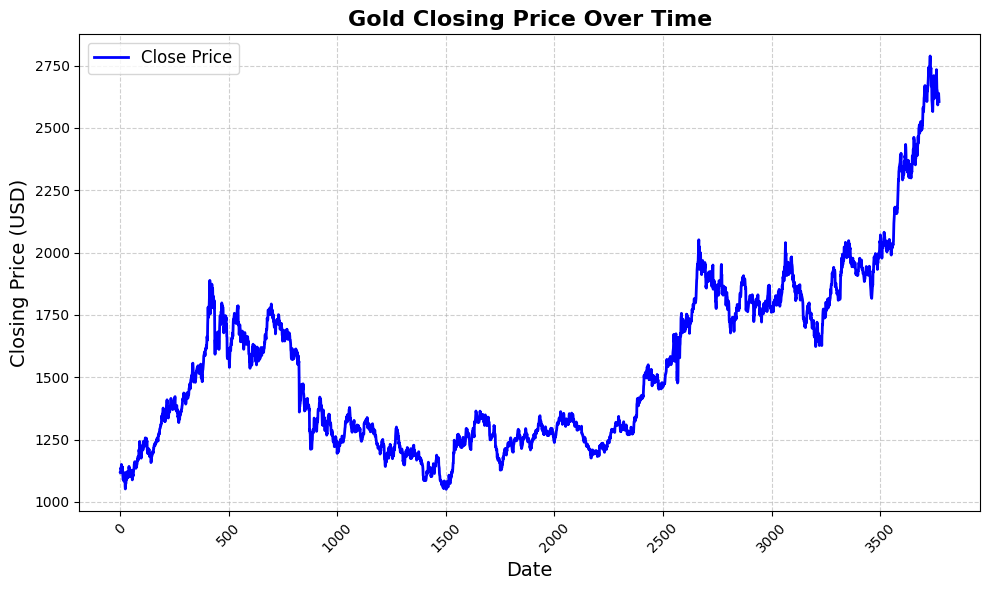

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df['Close'], color='blue', linewidth=2, label='Close Price')

plt.title('Gold Closing Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

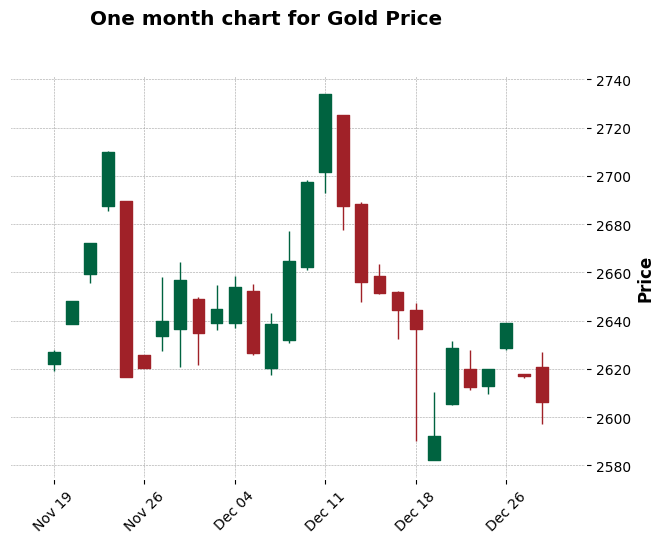

In [12]:
df_year = df.iloc[-30:].copy()
df_year['Date'] = pd.to_datetime(df_year['Date'])
df_year.set_index('Date', inplace=True)
df_year.dropna(inplace=True)
mpf.plot(df_year, type='candle', style='charles', title='One month chart for Gold Price')

In [13]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_lengths = [14]

for length in rsi_lengths:
    df[f'RSI_{length}'] = calculate_rsi(df['Close'], length)

df

,Date,Close,High,Low,Open,Volume,DXY,RSI_14
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184.0,77.52999877929688,NaN
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53.0,77.62000274658203,NaN
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363.0,77.48999786376953,NaN
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56.0,77.91000366210938,NaN
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54.0,77.47000122070312,NaN
...,...,...,...,...,...,...,...,...
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734,51.858616
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047,46.832424
3771,2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794.0,108.12999725341797,40.886580
3772,NaT,NaN,NaN,NaN,NaN,NaN,108.0,34.218691


In [14]:
def calculate_ma(data, window):
    return data.rolling(window=window).mean()

def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

ma_lengths = [12,26,50,200]
ema_lengths = [12,26,50,200]

for length in ma_lengths:
    df[f'MA_{length}'] = calculate_ma(df['Close'], length)

for length in ema_lengths:
    df[f'EMA_{length}'] = calculate_ema(df['Close'], length)

df

,Date,Close,High,Low,Open,Volume,DXY,RSI_14,MA_12,MA_26,MA_50,MA_200,EMA_12,EMA_26,EMA_50,EMA_200
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184.0,77.52999877929688,NaN,NaN,NaN,NaN,NaN,1117.699951,1117.699951,1117.699951,1117.699951
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53.0,77.62000274658203,NaN,NaN,NaN,NaN,NaN,1117.761493,1117.729583,1117.715638,1117.703932
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363.0,77.48999786376953,NaN,NaN,NaN,NaN,NaN,1120.552037,1119.075541,1118.428752,1117.884987
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56.0,77.91000366210938,NaN,NaN,NaN,NaN,NaN,1122.482489,1120.114388,1119.004094,1118.036380
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54.0,77.47000122070312,NaN,NaN,NaN,NaN,NaN,1124.900560,1121.454060,1119.756872,1118.237013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734,51.858616,2649.933329,2648.230769,2668.665996,2470.839995,2636.979948,2645.275922,2641.453220,2473.921766
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047,46.832424,2643.233317,2647.849994,2667.529995,2473.048995,2633.936872,2643.196221,2640.502111,2475.347420
3771,2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794.0,108.12999725341797,40.886580,2632.591654,2646.230769,2665.831997,2475.264496,2629.654291,2640.448360,2639.153013,2476.648442
3772,NaT,NaN,NaN,NaN,NaN,NaN,108.0,34.218691,NaN,NaN,NaN,NaN,2629.654291,2640.448360,2639.153013,2476.648442


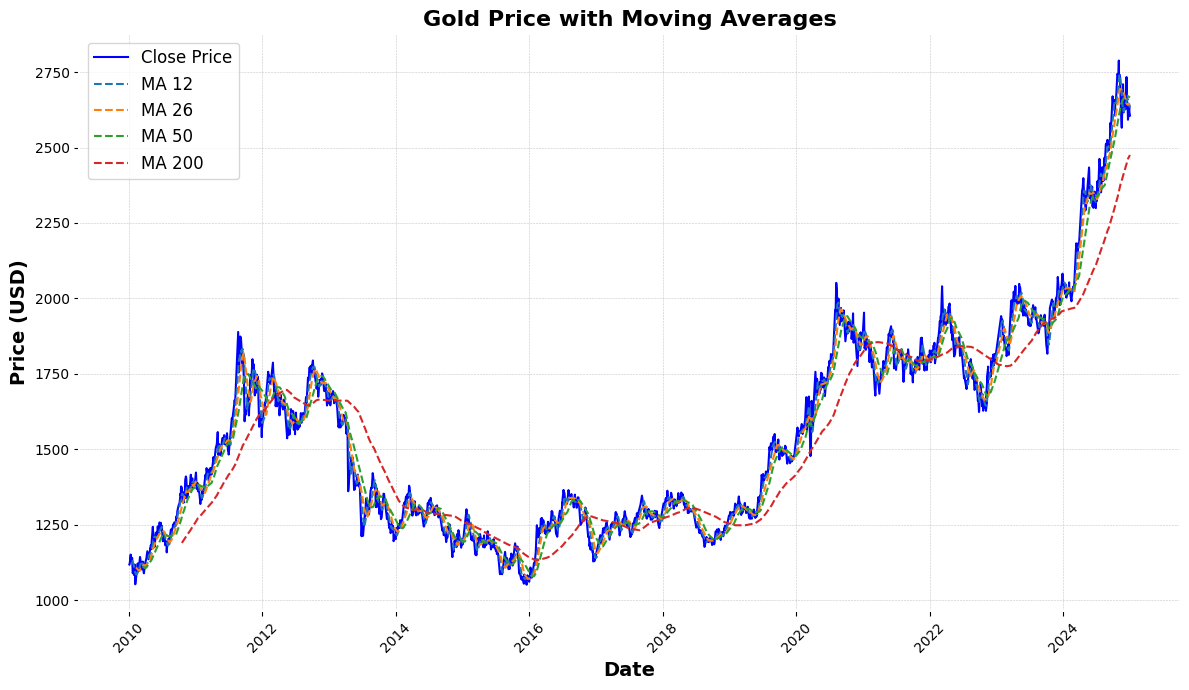

In [15]:
plt.figure(figsize=(12, 7))

plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=1.5)

for length in ma_lengths:
    plt.plot(df['Date'], df[f'MA_{length}'], label=f'MA {length}', linewidth=1.5, linestyle='--')


plt.title('Gold Price with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

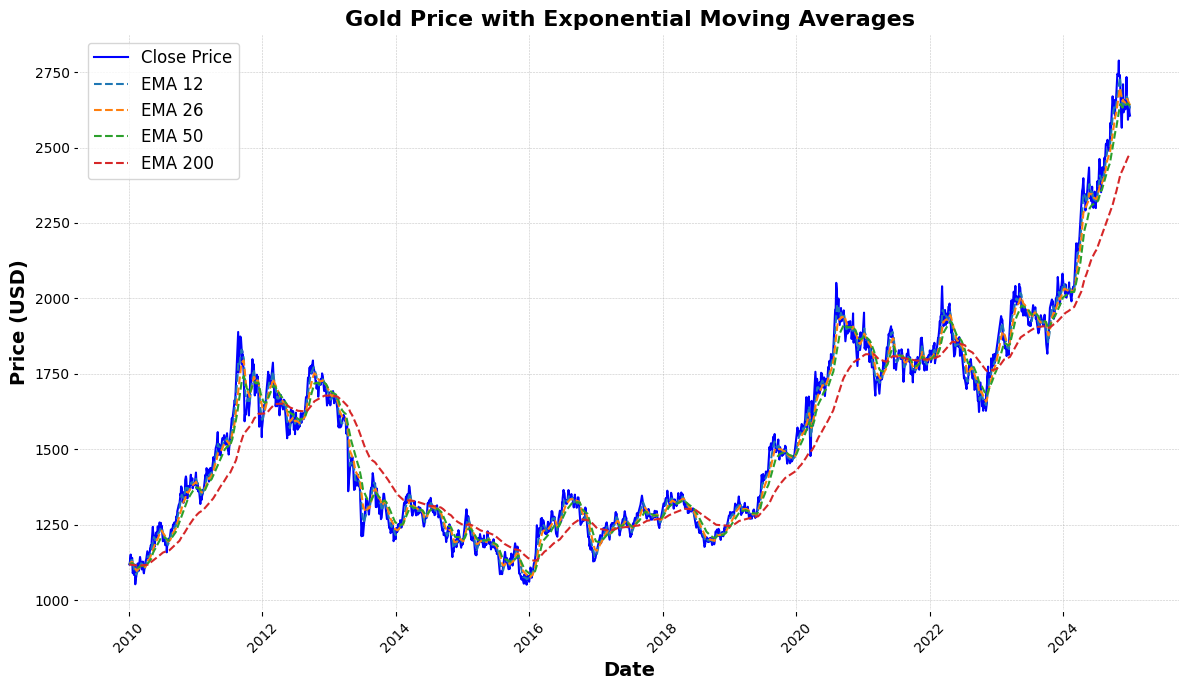

In [16]:
plt.figure(figsize=(12, 7))

plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=1.5)

for length in ema_lengths:
    plt.plot(df['Date'], df[f'EMA_{length}'], label=f'EMA {length}', linewidth=1.5, linestyle='--')


plt.title('Gold Price with Exponential Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
def calc_fib_levels(df, window=30):
    fib_ratios = [0.236, 0.382, 0.5, 0.618, 0.786]
    levels = pd.DataFrame(index=df.index)

    highs = df['High'].rolling(window=window)
    lows = df['Low'].rolling(window=window)

    for ratio in fib_ratios:
        levels[f'Fib_{int(ratio*100)}'] = highs.max() - (highs.max() - lows.min()) * ratio

    return levels
fib_levels = calc_fib_levels(df, window=30)
df = pd.concat([df, fib_levels], axis=1)
df = df.dropna()

In [18]:
window_size = 30
df['Volatility_30'] = df['Close'].rolling(window=window_size).std()

In [19]:
df['Daily_Return'] = df['Close'].pct_change()
for lag in [30]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

In [20]:
df['Day'] = df['Date'].dt.day_name()
df

,Date,Close,High,Low,Open,Volume,DXY,RSI_14,MA_12,MA_26,...,EMA_200,Fib_23,Fib_38,Fib_50,Fib_61,Fib_78,Volatility_30,Daily_Return,Close_Lag_30,Day
201,2010-10-18,1371.199951,1372.599976,1358.000000,1358.000000,46.0,76.93000030517578,77.188559,1348.533325,1313.957684,...,1210.344653,1350.907213,1330.496406,1314.000000,1297.503594,1274.017186,NaN,NaN,NaN,Monday
202,2010-10-19,1335.099976,1370.500000,1328.500000,1366.800049,301.0,78.18000030517578,58.692809,1350.116659,1317.419222,...,1211.586000,1350.907213,1330.496406,1314.000000,1297.503594,1274.017186,NaN,-0.026327,NaN,Tuesday
203,2010-10-20,1343.300049,1345.800049,1334.199951,1336.000000,148.0,77.16999816894531,61.059190,1352.441661,1320.249995,...,1212.896587,1350.907213,1330.496406,1314.000000,1297.503594,1274.017186,NaN,0.006142,NaN,Wednesday
204,2010-10-21,1324.699951,1346.199951,1317.500000,1344.199951,102.0,77.41999816894531,52.517555,1351.258321,1322.480765,...,1214.009058,1351.001619,1330.649215,1314.200012,1297.750809,1274.331605,NaN,-0.013847,NaN,Thursday
205,2010-10-22,1324.400024,1328.099976,1319.000000,1326.699951,113.0,77.47000122070312,52.640843,1349.424988,1324.499995,...,1215.107476,1351.143213,1330.878406,1314.500000,1298.121594,1274.803186,NaN,-0.000226,NaN,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451.0,108.41000366210938,45.207115,2653.658325,2645.057692,...,2470.779921,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372,38.816100,-0.006239,2687.500000,Monday
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35.0,107.62000274658203,44.979194,2652.108317,2647.146156,...,2472.264698,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372,38.641609,0.002948,2611.199951,Tuesday
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734,51.858616,2649.933329,2648.230769,...,2473.921766,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372,37.968775,0.007176,2600.000000,Thursday
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047,46.832424,2643.233317,2647.849994,...,2475.347420,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372,36.591163,-0.008186,2580.800049,Friday


In [21]:
encoder = OneHotEncoder(sparse_output=False)

day_reshaped = df['Day'].values.reshape(-1, 1)

day_encoded = encoder.fit_transform(day_reshaped)
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['Day']), index=df.index)

df = pd.concat([df, day_encoded_df], axis=1)

df.drop('Day', axis=1, inplace=True)

df

,Date,Close,High,Low,Open,Volume,DXY,RSI_14,MA_12,MA_26,...,Fib_61,Fib_78,Volatility_30,Daily_Return,Close_Lag_30,Day_Friday,Day_Monday,Day_Thursday,Day_Tuesday,Day_Wednesday
201,2010-10-18,1371.199951,1372.599976,1358.000000,1358.000000,46.0,76.93000030517578,77.188559,1348.533325,1313.957684,...,1297.503594,1274.017186,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
202,2010-10-19,1335.099976,1370.500000,1328.500000,1366.800049,301.0,78.18000030517578,58.692809,1350.116659,1317.419222,...,1297.503594,1274.017186,NaN,-0.026327,NaN,0.0,0.0,0.0,1.0,0.0
203,2010-10-20,1343.300049,1345.800049,1334.199951,1336.000000,148.0,77.16999816894531,61.059190,1352.441661,1320.249995,...,1297.503594,1274.017186,NaN,0.006142,NaN,0.0,0.0,0.0,0.0,1.0
204,2010-10-21,1324.699951,1346.199951,1317.500000,1344.199951,102.0,77.41999816894531,52.517555,1351.258321,1322.480765,...,1297.750809,1274.331605,NaN,-0.013847,NaN,0.0,0.0,1.0,0.0,0.0
205,2010-10-22,1324.400024,1328.099976,1319.000000,1326.699951,113.0,77.47000122070312,52.640843,1349.424988,1324.499995,...,1298.121594,1274.803186,NaN,-0.000226,NaN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451.0,108.41000366210938,45.207115,2653.658325,2645.057692,...,2622.807188,2592.634372,38.816100,-0.006239,2687.500000,0.0,1.0,0.0,0.0,0.0
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35.0,107.62000274658203,44.979194,2652.108317,2647.146156,...,2622.807188,2592.634372,38.641609,0.002948,2611.199951,0.0,0.0,0.0,1.0,0.0
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734,51.858616,2649.933329,2648.230769,...,2622.807188,2592.634372,37.968775,0.007176,2600.000000,0.0,0.0,1.0,0.0,0.0
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047,46.832424,2643.233317,2647.849994,...,2622.807188,2592.634372,36.591163,-0.008186,2580.800049,1.0,0.0,0.0,0.0,0.0


In [22]:
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Week_of_Year'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df

,Date,Close,High,Low,Open,Volume,DXY,RSI_14,MA_12,MA_26,...,Close_Lag_30,Day_Friday,Day_Monday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day_of_Year,Week_of_Year,Month,Year
201,2010-10-18,1371.199951,1372.599976,1358.000000,1358.000000,46.0,76.93000030517578,77.188559,1348.533325,1313.957684,...,NaN,0.0,1.0,0.0,0.0,0.0,291,42,10,2010
202,2010-10-19,1335.099976,1370.500000,1328.500000,1366.800049,301.0,78.18000030517578,58.692809,1350.116659,1317.419222,...,NaN,0.0,0.0,0.0,1.0,0.0,292,42,10,2010
203,2010-10-20,1343.300049,1345.800049,1334.199951,1336.000000,148.0,77.16999816894531,61.059190,1352.441661,1320.249995,...,NaN,0.0,0.0,0.0,0.0,1.0,293,42,10,2010
204,2010-10-21,1324.699951,1346.199951,1317.500000,1344.199951,102.0,77.41999816894531,52.517555,1351.258321,1322.480765,...,NaN,0.0,0.0,1.0,0.0,0.0,294,42,10,2010
205,2010-10-22,1324.400024,1328.099976,1319.000000,1326.699951,113.0,77.47000122070312,52.640843,1349.424988,1324.499995,...,NaN,1.0,0.0,0.0,0.0,0.0,295,42,10,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451.0,108.41000366210938,45.207115,2653.658325,2645.057692,...,2687.500000,0.0,1.0,0.0,0.0,0.0,358,52,12,2024
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35.0,107.62000274658203,44.979194,2652.108317,2647.146156,...,2611.199951,0.0,0.0,0.0,1.0,0.0,359,52,12,2024
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84.0,108.04000091552734,51.858616,2649.933329,2648.230769,...,2600.000000,0.0,0.0,1.0,0.0,0.0,361,52,12,2024
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642.0,108.26000213623047,46.832424,2643.233317,2647.849994,...,2580.800049,1.0,0.0,0.0,0.0,0.0,362,52,12,2024


In [23]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'DXY', 'RSI_14',
       'MA_12', 'MA_26', 'MA_50', 'MA_200', 'EMA_12', 'EMA_26', 'EMA_50',
       'EMA_200', 'Fib_23', 'Fib_38', 'Fib_50', 'Fib_61', 'Fib_78',
       'Volatility_30', 'Daily_Return', 'Close_Lag_30', 'Day_Friday',
       'Day_Monday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
       'Day_of_Year', 'Week_of_Year', 'Month', 'Year'],
      dtype='object')

In [24]:
df['Target'] = df['Close'].shift(-1)
df = df.dropna()

feature_columns = ['Close', 'High', 'Low', 'Open', 'Volatility_30',
       'RSI_14','MA_12', 'MA_26',
       'MA_50', 'MA_200', 'EMA_12', 'EMA_26',
       'EMA_50', 'EMA_200', 'Fib_23', 'Fib_38',
       'Fib_50', 'Fib_61', 'Fib_78', 'Close_Lag_30'] +  \
       list(day_encoded_df.columns)

features_to_scale = df[feature_columns]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_to_scale)
scaler_y = MinMaxScaler()
scaled_target = scaler_y.fit_transform(df[['Target']])

def create_sequences(features, target, sequence_length=30):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
class GoldPriceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), \
               torch.tensor(self.targets[idx], dtype=torch.float32)

train_dataset = GoldPriceDataset(X_train, y_train)
test_dataset = GoldPriceDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class GoldPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GoldPricePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = len(feature_columns)
hidden_size = 128
num_layers = 2
output_size = 1

model = GoldPricePredictor(input_size, hidden_size, num_layers, output_size)
print(model)

GoldPricePredictor(
  (lstm): LSTM(25, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs = 50
train_losses = []
test_losses = []

Epoch 1/50: 100%|██████████| 44/44 [00:01<00:00, 34.35it/s, loss=0.00603]


Epoch 1/50, Train Loss: 0.021365, Test Loss: 0.011343


Epoch 2/50: 100%|██████████| 44/44 [00:00<00:00, 98.53it/s, loss=0.0353] 


Epoch 2/50, Train Loss: 0.018076, Test Loss: 0.078664


Epoch 3/50: 100%|██████████| 44/44 [00:00<00:00, 90.30it/s, loss=0.0467]


Epoch 3/50, Train Loss: 0.022602, Test Loss: 0.090510


Epoch 4/50: 100%|██████████| 44/44 [00:00<00:00, 112.07it/s, loss=0.0242]


Epoch 4/50, Train Loss: 0.015675, Test Loss: 0.049327


Epoch 5/50: 100%|██████████| 44/44 [00:00<00:00, 98.51it/s, loss=0.0137]


Epoch 5/50, Train Loss: 0.010898, Test Loss: 0.033572


Epoch 6/50: 100%|██████████| 44/44 [00:00<00:00, 83.18it/s, loss=0.0052]


Epoch 6/50, Train Loss: 0.006567, Test Loss: 0.020875


Epoch 7/50: 100%|██████████| 44/44 [00:00<00:00, 145.37it/s, loss=0.00265]


Epoch 7/50, Train Loss: 0.004155, Test Loss: 0.016768


Epoch 8/50: 100%|██████████| 44/44 [00:00<00:00, 149.22it/s, loss=0.0016]


Epoch 8/50, Train Loss: 0.001850, Test Loss: 0.014564


Epoch 9/50: 100%|██████████| 44/44 [00:00<00:00, 149.37it/s, loss=0.000991]


Epoch 9/50, Train Loss: 0.000871, Test Loss: 0.011769


Epoch 10/50: 100%|██████████| 44/44 [00:00<00:00, 147.75it/s, loss=0.000887]


Epoch 10/50, Train Loss: 0.000799, Test Loss: 0.010026


Epoch 11/50: 100%|██████████| 44/44 [00:00<00:00, 146.60it/s, loss=0.000733]


Epoch 11/50, Train Loss: 0.000770, Test Loss: 0.008611


Epoch 12/50: 100%|██████████| 44/44 [00:00<00:00, 151.60it/s, loss=0.000636]


Epoch 12/50, Train Loss: 0.000736, Test Loss: 0.007462


Epoch 13/50: 100%|██████████| 44/44 [00:00<00:00, 181.61it/s, loss=0.000557]


Epoch 13/50, Train Loss: 0.000729, Test Loss: 0.006471


Epoch 14/50: 100%|██████████| 44/44 [00:00<00:00, 171.59it/s, loss=0.000496]


Epoch 14/50, Train Loss: 0.000732, Test Loss: 0.005623


Epoch 15/50: 100%|██████████| 44/44 [00:00<00:00, 186.86it/s, loss=0.00045]


Epoch 15/50, Train Loss: 0.000748, Test Loss: 0.004905


Epoch 16/50: 100%|██████████| 44/44 [00:00<00:00, 188.85it/s, loss=0.00042]


Epoch 16/50, Train Loss: 0.000777, Test Loss: 0.004310


Epoch 17/50: 100%|██████████| 44/44 [00:00<00:00, 191.28it/s, loss=0.000402]


Epoch 17/50, Train Loss: 0.000820, Test Loss: 0.003834


Epoch 18/50: 100%|██████████| 44/44 [00:00<00:00, 180.80it/s, loss=0.000393]


Epoch 18/50, Train Loss: 0.000873, Test Loss: 0.003462


Epoch 19/50: 100%|██████████| 44/44 [00:00<00:00, 188.88it/s, loss=0.000388]


Epoch 19/50, Train Loss: 0.000927, Test Loss: 0.003174


Epoch 20/50: 100%|██████████| 44/44 [00:00<00:00, 189.77it/s, loss=0.000385]


Epoch 20/50, Train Loss: 0.000975, Test Loss: 0.002944


Epoch 21/50: 100%|██████████| 44/44 [00:00<00:00, 191.07it/s, loss=0.000382]


Epoch 21/50, Train Loss: 0.001007, Test Loss: 0.002749


Epoch 22/50: 100%|██████████| 44/44 [00:00<00:00, 182.66it/s, loss=0.00038]


Epoch 22/50, Train Loss: 0.001020, Test Loss: 0.002571


Epoch 23/50: 100%|██████████| 44/44 [00:00<00:00, 188.97it/s, loss=0.000378]


Epoch 23/50, Train Loss: 0.001016, Test Loss: 0.002403


Epoch 24/50: 100%|██████████| 44/44 [00:00<00:00, 193.93it/s, loss=0.000377]


Epoch 24/50, Train Loss: 0.000999, Test Loss: 0.002242


Epoch 25/50: 100%|██████████| 44/44 [00:00<00:00, 192.95it/s, loss=0.000378]


Epoch 25/50, Train Loss: 0.000976, Test Loss: 0.002090


Epoch 26/50: 100%|██████████| 44/44 [00:00<00:00, 182.40it/s, loss=0.000379]


Epoch 26/50, Train Loss: 0.000951, Test Loss: 0.001949


Epoch 27/50: 100%|██████████| 44/44 [00:00<00:00, 200.81it/s, loss=0.000382]


Epoch 27/50, Train Loss: 0.000926, Test Loss: 0.001820


Epoch 28/50: 100%|██████████| 44/44 [00:00<00:00, 191.78it/s, loss=0.000385]


Epoch 28/50, Train Loss: 0.000904, Test Loss: 0.001705


Epoch 29/50: 100%|██████████| 44/44 [00:00<00:00, 189.03it/s, loss=0.000389]


Epoch 29/50, Train Loss: 0.000885, Test Loss: 0.001603


Epoch 30/50: 100%|██████████| 44/44 [00:00<00:00, 168.08it/s, loss=0.000393]


Epoch 30/50, Train Loss: 0.000868, Test Loss: 0.001514


Epoch 31/50: 100%|██████████| 44/44 [00:00<00:00, 183.12it/s, loss=0.000398]


Epoch 31/50, Train Loss: 0.000853, Test Loss: 0.001437


Epoch 32/50: 100%|██████████| 44/44 [00:00<00:00, 191.08it/s, loss=0.000403]


Epoch 32/50, Train Loss: 0.000840, Test Loss: 0.001371


Epoch 33/50: 100%|██████████| 44/44 [00:00<00:00, 193.19it/s, loss=0.000408]


Epoch 33/50, Train Loss: 0.000829, Test Loss: 0.001314


Epoch 34/50: 100%|██████████| 44/44 [00:00<00:00, 181.62it/s, loss=0.000413]


Epoch 34/50, Train Loss: 0.000818, Test Loss: 0.001266


Epoch 35/50: 100%|██████████| 44/44 [00:00<00:00, 197.48it/s, loss=0.000418]


Epoch 35/50, Train Loss: 0.000809, Test Loss: 0.001226


Epoch 36/50: 100%|██████████| 44/44 [00:00<00:00, 189.22it/s, loss=0.000423]


Epoch 36/50, Train Loss: 0.000800, Test Loss: 0.001192


Epoch 37/50: 100%|██████████| 44/44 [00:00<00:00, 190.17it/s, loss=0.000427]


Epoch 37/50, Train Loss: 0.000791, Test Loss: 0.001164


Epoch 38/50: 100%|██████████| 44/44 [00:00<00:00, 176.07it/s, loss=0.000432]


Epoch 38/50, Train Loss: 0.000783, Test Loss: 0.001142


Epoch 39/50: 100%|██████████| 44/44 [00:00<00:00, 190.25it/s, loss=0.000437]


Epoch 39/50, Train Loss: 0.000774, Test Loss: 0.001125


Epoch 40/50: 100%|██████████| 44/44 [00:00<00:00, 188.67it/s, loss=0.000441]


Epoch 40/50, Train Loss: 0.000766, Test Loss: 0.001112


Epoch 41/50: 100%|██████████| 44/44 [00:00<00:00, 187.36it/s, loss=0.000445]


Epoch 41/50, Train Loss: 0.000758, Test Loss: 0.001104


Epoch 42/50: 100%|██████████| 44/44 [00:00<00:00, 185.82it/s, loss=0.000449]


Epoch 42/50, Train Loss: 0.000749, Test Loss: 0.001099


Epoch 43/50: 100%|██████████| 44/44 [00:00<00:00, 187.18it/s, loss=0.000454]


Epoch 43/50, Train Loss: 0.000741, Test Loss: 0.001098


Epoch 44/50: 100%|██████████| 44/44 [00:00<00:00, 190.87it/s, loss=0.000458]


Epoch 44/50, Train Loss: 0.000733, Test Loss: 0.001101


Epoch 45/50: 100%|██████████| 44/44 [00:00<00:00, 183.42it/s, loss=0.000462]


Epoch 45/50, Train Loss: 0.000725, Test Loss: 0.001107


Epoch 46/50: 100%|██████████| 44/44 [00:00<00:00, 189.24it/s, loss=0.000465]


Epoch 46/50, Train Loss: 0.000717, Test Loss: 0.001116


Epoch 47/50: 100%|██████████| 44/44 [00:00<00:00, 196.38it/s, loss=0.000469]


Epoch 47/50, Train Loss: 0.000710, Test Loss: 0.001129


Epoch 48/50: 100%|██████████| 44/44 [00:00<00:00, 190.67it/s, loss=0.000473]


Epoch 48/50, Train Loss: 0.000702, Test Loss: 0.001146


Epoch 49/50: 100%|██████████| 44/44 [00:00<00:00, 178.32it/s, loss=0.000477]


Epoch 49/50, Train Loss: 0.000695, Test Loss: 0.001165


Epoch 50/50: 100%|██████████| 44/44 [00:00<00:00, 154.51it/s, loss=0.000321]


Epoch 50/50, Train Loss: 0.000508, Test Loss: 0.000525


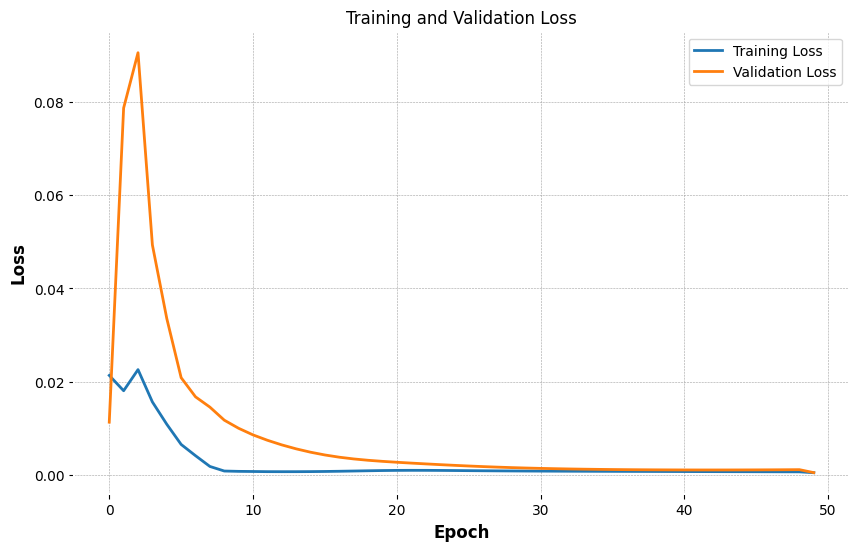

In [28]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({'loss': loss.item()})
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    scheduler.step(epoch_test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

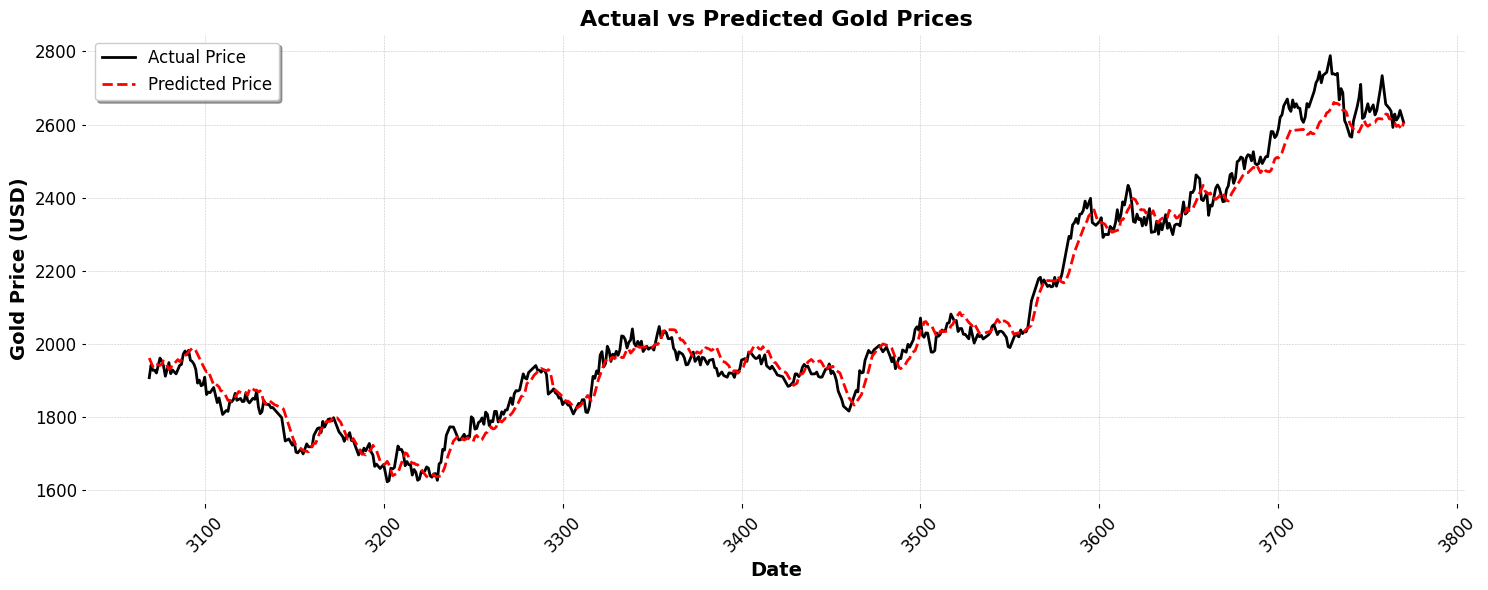

In [29]:
def inverse_transform(scaler, data, feature_index):
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, feature_index] = data.reshape(-1)
    return scaler.inverse_transform(dummy)[:, feature_index]

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

predictions = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(predictions), 0)
actuals = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(actuals), 0)

results_df = pd.DataFrame({
    'Date': df.index[-len(actuals):],
    'Actual': actuals,
    'Predicted': predictions
})

plt.figure(figsize=(15,6))
plt.plot(results_df['Date'],results_df['Actual'],label='Actual Price',color='black',linewidth=2)
plt.plot(results_df['Date'],results_df['Predicted'],label='Predicted Price',color='red',linestyle='--',linewidth=2)
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Gold Price (USD)',fontsize=14,fontweight='bold')
plt.title('Actual vs Predicted Gold Prices',fontsize=16,fontweight='bold')
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.grid(True,linestyle='--',alpha=0.6)
plt.legend(fontsize=12,loc='upper left',frameon=True,fancybox=True,shadow=True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2) Score: {r2:.4f}')

percentage_errors = np.abs((actuals - predictions) / actuals) * 100
mean_ape = np.mean(percentage_errors)
print(f'Mean Absolute Percentage Error (MAPE): {mean_ape:.2f}%')

Mean Absolute Error (MAE): 30.74
Mean Squared Error (MSE): 1585.13
Root Mean Squared Error (RMSE): 39.81
R-squared (R2) Score: 0.9818
Mean Absolute Percentage Error (MAPE): 1.46%


In [31]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=0.1, device="cpu"):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.weight_mu  = nn.Parameter(torch.zeros(out_features, in_features, device=device))
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), -3.0, device=device))
        self.bias_mu    = nn.Parameter(torch.zeros(out_features, device=device))
        self.bias_rho   = nn.Parameter(torch.full((out_features,), -3.0, device=device))
        self.register_buffer("prior_sigma", torch.tensor(prior_sigma, device=device))
        self.register_buffer("prior_var", self.prior_sigma ** 2)

    def _sample_weights(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma   = torch.log1p(torch.exp(self.bias_rho))

        eps_w = torch.randn_like(self.weight_mu, device=self.device)
        eps_b = torch.randn_like(self.bias_mu,   device=self.device)

        weight = self.weight_mu + weight_sigma * eps_w
        bias   = self.bias_mu   + bias_sigma   * eps_b
        return weight, bias, weight_sigma, bias_sigma

    def kl_divergence(self, weight_mu, weight_sigma, bias_mu, bias_sigma):
        var_ratio_w = (weight_sigma ** 2) / self.prior_var
        var_ratio_b = (bias_sigma  ** 2) / self.prior_var

        kl_w = torch.sum(
            torch.log(self.prior_sigma / weight_sigma)
            + (var_ratio_w + (weight_mu ** 2) / self.prior_var) * 0.5
            - 0.5
        )
        kl_b = torch.sum(
            torch.log(self.prior_sigma / bias_sigma)
            + (var_ratio_b + (bias_mu ** 2) / self.prior_var) * 0.5
            - 0.5
        )
        return kl_w + kl_b

    def forward(self, x):
        W, b, Wsig, bsig = self._sample_weights()
        out = x @ W.t() + b
        kl = self.kl_divergence(self.weight_mu, Wsig, self.bias_mu, bsig)
        return out, kl


class BayesianLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.device      = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.bayes_fc = BayesianLinear(hidden_size, output_size, prior_sigma=0.1, device=device)

    def forward(self, x):
        batch = x.size(0)
        h0 = torch.zeros(self.num_layers, batch, self.hidden_size, device=self.device)
        c0 = torch.zeros(self.num_layers, batch, self.hidden_size, device=self.device)
        out, _ = self.lstm(x, (h0, c0))
        last = out[:, -1, :]
        yhat, kl = self.bayes_fc(last)
        return yhat, kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bayes_model = BayesianLSTMModel(input_size, hidden_size, num_layers, output_size, device).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bayes_model.parameters(), lr=0.001)

num_epochs = 50
kl_weight  = 1.0 / len(train_loader.dataset)

for epoch in range(num_epochs):
    bayes_model.train()
    running = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds, kl = bayes_model(inputs)
        mse = criterion(preds, labels)
        loss = mse + kl_weight * kl

        loss.backward()
        optimizer.step()
        running += loss.item() * inputs.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}  |  Loss: {running/len(train_loader.dataset):.6f}")


bayes_model.eval()
n_samples = 200
predictions, uncertainties, actuals = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        mc = []
        for _ in range(n_samples):
            out, _ = bayes_model(inputs)
            mc.append(out.cpu().numpy())
        mc = np.array(mc)
        mean = mc.mean(axis=0).squeeze(-1)
        std  = mc.std(axis=0).squeeze(-1)

        predictions.extend(mean)
        uncertainties.extend(std)
        actuals.extend(labels.cpu().numpy().squeeze(-1))

predictions = np.array(predictions)
actuals     = np.array(actuals)
uncertainties = np.array(uncertainties)

predictions_transformed = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(predictions), 0)
actuals_transformed = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(actuals), 0)

mae = mean_absolute_error(actuals_transformed, predictions_transformed)
mse = mean_squared_error(actuals_transformed, predictions_transformed)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_transformed, predictions_transformed)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2) Score: {r2:.4f}')

percentage_errors = np.abs((actuals_transformed - predictions_transformed) / actuals_transformed) * 100
mean_ape = np.mean(percentage_errors)
print(f'Mean Absolute Percentage Error (MAPE): {mean_ape:.2f}%')


Epoch 1/50  |  Loss: 0.037883
Epoch 2/50  |  Loss: 0.040689
Epoch 3/50  |  Loss: 0.040844
Epoch 4/50  |  Loss: 0.043117
Epoch 5/50  |  Loss: 0.033487
Epoch 6/50  |  Loss: 0.024515
Epoch 7/50  |  Loss: 0.020133
Epoch 8/50  |  Loss: 0.021553
Epoch 9/50  |  Loss: 0.022350
Epoch 10/50  |  Loss: 0.031221
Epoch 11/50  |  Loss: 0.022943
Epoch 12/50  |  Loss: 0.016447
Epoch 13/50  |  Loss: 0.017412
Epoch 14/50  |  Loss: 0.016217
Epoch 15/50  |  Loss: 0.015944
Epoch 16/50  |  Loss: 0.015156
Epoch 17/50  |  Loss: 0.014437
Epoch 18/50  |  Loss: 0.013887
Epoch 19/50  |  Loss: 0.014833
Epoch 20/50  |  Loss: 0.016969
Epoch 21/50  |  Loss: 0.017553
Epoch 22/50  |  Loss: 0.015721
Epoch 23/50  |  Loss: 0.013773
Epoch 24/50  |  Loss: 0.016395
Epoch 25/50  |  Loss: 0.012436
Epoch 26/50  |  Loss: 0.014581
Epoch 27/50  |  Loss: 0.011270
Epoch 28/50  |  Loss: 0.011146
Epoch 29/50  |  Loss: 0.011449
Epoch 30/50  |  Loss: 0.012110
Epoch 31/50  |  Loss: 0.009384
Epoch 32/50  |  Loss: 0.010230
Epoch 33/50  |  L

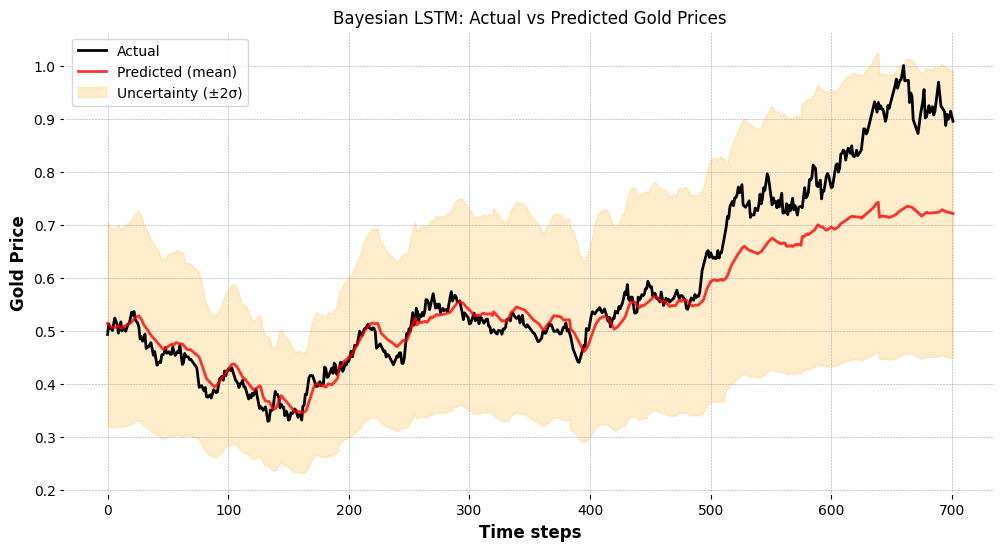

In [32]:
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Actual", color="black", linewidth=2)
plt.plot(predictions, label="Predicted (mean)", color="red", alpha=0.8)

upper = predictions + 2 * uncertainties
lower = predictions - 2 * uncertainties
plt.fill_between(range(len(predictions)), lower, upper, color="orange", alpha=0.2, label="Uncertainty (±2σ)")

plt.title("Bayesian LSTM: Actual vs Predicted Gold Prices")
plt.xlabel("Time steps")
plt.ylabel("Gold Price")
plt.legend()
plt.show()

In [33]:
torch.save(model.state_dict(), "lstm_model.pth")

In [34]:
torch.save(bayes_model.state_dict(), "bayes_model.pth")